# Forecasting Air Passenger using SVM

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR

# perosnal wrapper created for time-series plots
import ts_utils

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [3]:
warnings.filterwarnings("ignore")

## Data preparation

In [4]:
DATADIR = '../data/air-passenger/'
data_path = os.path.join(DATADIR, 'AirPassengers.csv')
MODELDIR = '../checkpoints/air-passenger/svm/model/'

In [5]:
df = pd.read_csv(data_path, usecols=[1], header=0, engine='python')
data = df.values
data = data.astype('float32')

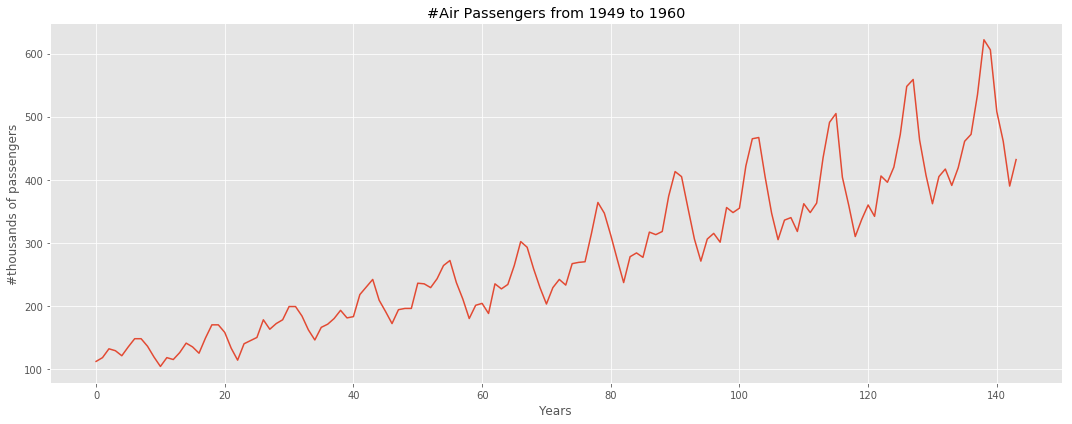

In [6]:
plt.plot(data)
plt.title('#Air Passengers from 1949 to 1960')
plt.ylabel('#thousands of passengers')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

In [7]:
scaled_data = np.log(data)
print(scaled_data[:5])

[[4.7184987]
 [4.7706847]
 [4.882802 ]
 [4.8598123]
 [4.7957907]]


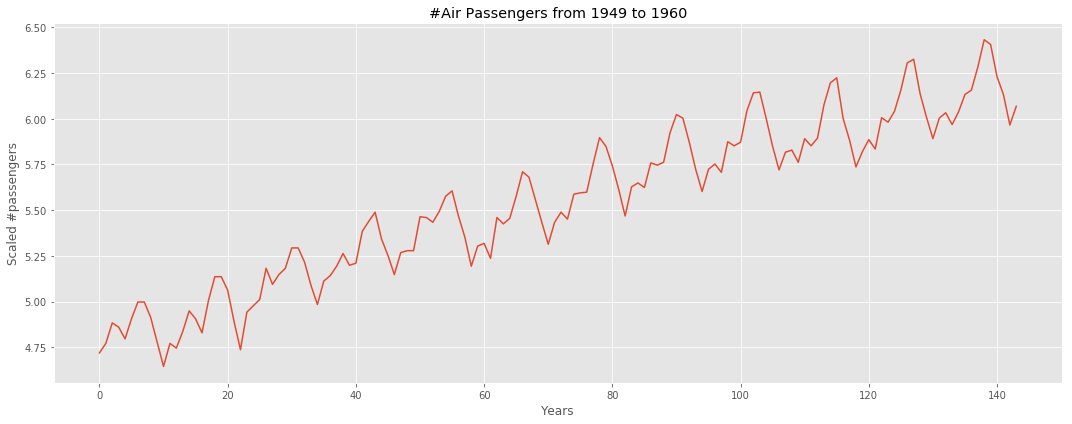

In [8]:
plt.plot(scaled_data)
plt.title('#Air Passengers from 1949 to 1960')
plt.ylabel('Scaled #passengers')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

## Train test split

In [9]:
train, test = train_test_split(scaled_data, train_size=0.8 ,shuffle=False)
len(train), len(test)

(115, 29)

In [10]:
X_train, y_train = ts_utils.prepare_data(train, time_step=1)
X_test, y_test = ts_utils.prepare_data(test, time_step=1)
print(X_train.shape) 
print(X_test.shape)

(113, 1)
(27, 1)


## Parameter selection using Grid search

In [11]:
# grid_param = {
#     'C': [0.1, 1, 10],
#     'epsilon' : [0.1, 0.2, 0.3]
# }

In [12]:
# provide the memory for cache using cache_size
# here, 5GB is provided for faster computation
# svm = SVR(gamma='scale', cache_size=5120)

In [13]:
# svm_grid = GridSearchCV(estimator=svm, param_grid=grid_param)

In [14]:
# svm_grid.fit(X_train, y_train)

In [15]:
# print(f'Best estimator: {svm_grid.best_estimator_}')
# print(f'Best Paramters: {svm_grid.best_params_}')
# print(f'Best result: {svm_grid.best_score_}')

## Model fitting

In [16]:
param = {
    'C': 1000,
    'epsilon' : 0.1
}

In [17]:
model = SVR(**param, gamma='scale', cache_size=5120)
model.fit(X_train, y_train)

SVR(C=1000, cache_size=5120, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [18]:
import pickle

In [19]:
pickle.dump(model, open(os.path.join(MODELDIR, 'svm2.model'), 'wb'))

## Prediction and evaluation

In [20]:
# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# the results are in the form of scaled value, so inverse the transformation
y_train_pred_inv = np.exp(y_train_pred)
y_test_pred_inv = np.exp(y_test_pred)

# will be used for calculating MAE and RMSE
y_train_inv = np.exp(y_train)
y_test_inv = np.exp(y_test)

# MAE and RMSE calculation
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
train_nrmse = train_rmse/np.std(y_train_inv)

test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
test_nrmse = test_rmse/np.std(y_test_inv)

print(f'Training NRMSE: {train_nrmse}')
print(f'Training MAE: {train_mae}')

print(f'Test NRMSE: {test_nrmse}')
print(f'Test MAE: {test_mae}')

Training NRMSE: 0.29451421753680623
Training MAE: 20.492170625941743
Test NRMSE: 0.6794484146479106
Test MAE: 45.88874692453001


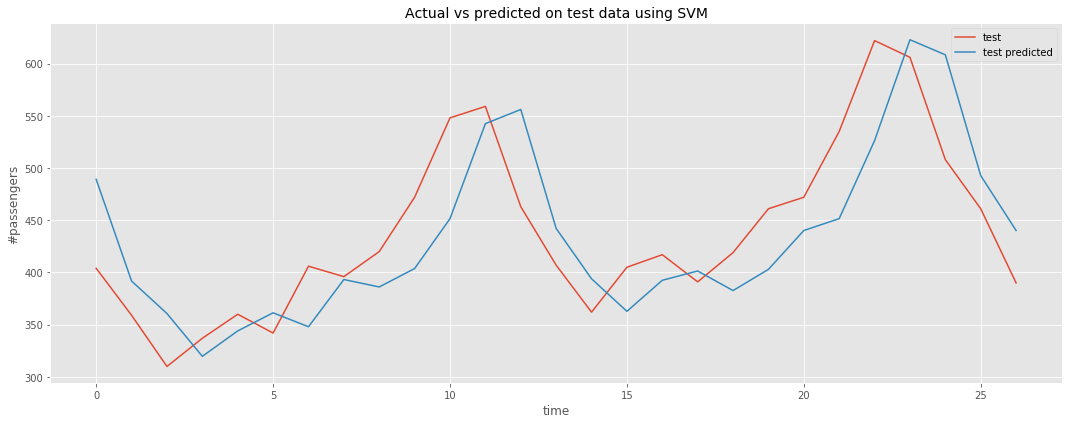

In [21]:
plt.plot(y_test_inv, label='test')
plt.plot(y_test_pred_inv, label='test predicted')
plt.xlabel('time')
plt.ylabel('#passengers')
plt.title('Actual vs predicted on test data using SVM', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

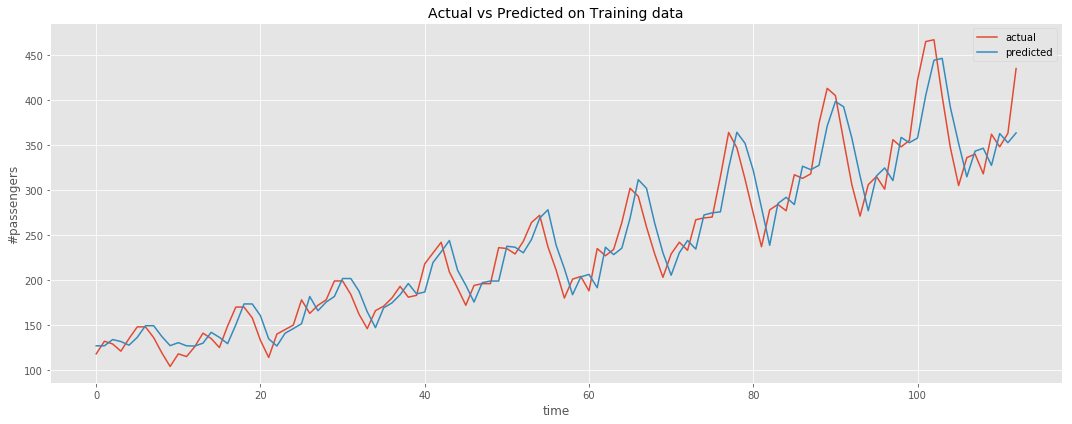

In [22]:
plt.plot(y_train_inv, label='actual')
plt.plot(y_train_pred_inv, label='predicted')
plt.ylabel('#passengers')
plt.xlabel('time')
plt.title('Actual vs Predicted on Training data', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
actual_data = np.vstack((y_train_inv, y_test_inv))

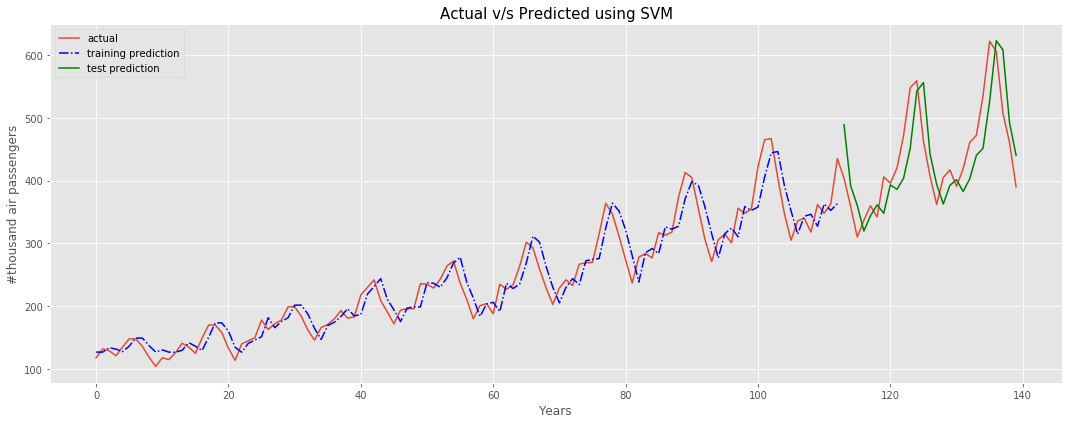

In [24]:
test_plot = np.empty_like(actual_data)
test_plot[:, :] = np.nan
test_plot[len(y_train_pred_inv):len(actual_data):, ] = y_test_pred_inv.reshape(-1, 1)

plt.plot(actual_data, label='actual')
plt.plot(y_train_pred_inv, color='blue', linestyle='-.', label='training prediction')
plt.plot(test_plot, color='green', linestyle='-', label='test prediction')
plt.xlabel('Years')
plt.ylabel('#thousand air passengers')
plt.title('Actual v/s Predicted using SVM', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()